# Spotify and Youtube songs data analysis
This notebook is designed to perform a series of data analysis operations on log data. It includes data loading, filtering, and statistical computations. Functions are clearly documented, and visualizations are included to support the analysis.

## Imports
The following libraries are imported for data manipulation and visualization:
- `pandas` for working with dataframes
- `numpy` for numerical operations
- `seaborn` and `matplotlib` for data visualization
- `os` and `math` for system and mathematical operations
- optionally, later we would also need `sklearn` for PCA alogrithm

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from sklearn.decomposition import PCA # used later
from sklearn.manifold import TSNE # used later
from sklearn.preprocessing import StandardScaler # used later

## Data Loading
This section defines a method to load the data from a CSV file. The method ensures proper parsing and conversion into a DataFrame.

In [3]:
# simple yet effective data download from csv file using pandas library

def load_data(filepath):
    """
    Load data function.

    """
    try:
        data = pd.read_csv(filepath)
        print("Data loaded successfully.")
        return data
    except FileNotFoundError:
        print("File not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

Then we need to filter the data to remove unnecessary columns.

In [4]:
# removing columns containing description, urls ,etc.

def filter_data(data):
    """
    Filter data function.

    """
    columns_to_exclude = [col for col in data.columns if col == 'Unnamed: 0' or col.lower() == 'uri' or 'url_' in col.lower() or 'description' in col.lower() or col == '']
    f_data = data[data.columns.difference(columns_to_exclude)]
    return f_data

Finally, we can load and filter our data.

In [5]:
data = filter_data(load_data('Spotify_Youtube.csv'))
data.head() # showcase of data

Data loaded successfully.


,Acousticness,Album,Album_type,Artist,Channel,Comments,Danceability,Duration_ms,Energy,Instrumentalness,...,Liveness,Loudness,Speechiness,Stream,Tempo,Title,Track,Valence,Views,official_video
0,0.008360,Demon Days,album,Gorillaz,Gorillaz,169907.0,0.818,222640.0,0.705,0.002330,...,0.6130,-6.679,0.1770,1.040235e+09,138.559,Gorillaz - Feel Good Inc. (Official Video),Feel Good Inc.,0.772,693555221.0,True
1,0.086900,Plastic Beach,album,Gorillaz,Gorillaz,31003.0,0.676,200173.0,0.703,0.000687,...,0.0463,-5.815,0.0302,3.100837e+08,92.761,Gorillaz - Rhinestone Eyes [Storyboard Film] (...,Rhinestone Eyes,0.852,72011645.0,True
2,0.042500,New Gold (feat. Tame Impala and Bootie Brown),single,Gorillaz,Gorillaz,7399.0,0.695,215150.0,0.923,0.046900,...,0.1160,-3.930,0.0522,6.306347e+07,108.014,Gorillaz - New Gold ft. Tame Impala & Bootie B...,New Gold (feat. Tame Impala and Bootie Brown),0.551,8435055.0,True
3,0.000015,Plastic Beach,album,Gorillaz,Gorillaz,55229.0,0.689,233867.0,0.739,0.509000,...,0.0640,-5.810,0.0260,4.346636e+08,120.423,Gorillaz - On Melancholy Hill (Official Video),On Melancholy Hill,0.578,211754952.0,True
4,0.025300,Gorillaz,album,Gorillaz,Gorillaz,155930.0,0.663,340920.0,0.694,0.000000,...,0.0698,-8.627,0.1710,6.172597e+08,167.953,Gorillaz - Clint Eastwood (Official Video),Clint Eastwood,0.525,618480958.0,True


Now we need to parse columns into according data types.

In [6]:
def parse_data(data):
    """
    Parse data function.

    """
    # for numerical data
    numeric_columns = data.select_dtypes(include=['number'])

    #for categorical data
    categorical_columns = data.select_dtypes(include=['object'])
    
    return numeric_columns, categorical_columns

After that we can do a basic data description (mean, min, max, ...) for numerical data and count unique classes and nulls for categorical data.

In [7]:
def basic_desc_data(numeric_columns, categorical_columns):
    """
    Basic desc data function.

    """
    # numerical data
    numeric_stats = numeric_columns.describe(percentiles=[0.05, 0.95]) # we use additional parameters to include different percentiles
    numeric_stats.loc['missing_values'] = numeric_columns.isnull().sum() # we sum nulls as well
    
    # categorical data
    categorical_stats = pd.DataFrame({ # crating DataFrame containing number of unique classes and number of missing values
            'unique_classes': categorical_columns.nunique(),
            'missing_values': categorical_columns.isnull().sum()
        })
    categorical_stats['proportion'] = None
    
    # adding proportion to every class
    for col in categorical_columns:
        categorical_stats.at[col, 'proportion'] = categorical_columns[col].value_counts(normalize=True, dropna=True).to_dict()
        
    return numeric_stats, categorical_stats

In [8]:
numeric_columns, categorical_columns = parse_data(data)
numeric_stats, categorical_stats = basic_desc_data(numeric_columns, categorical_columns)

numeric_stats.head()

,Acousticness,Comments,Danceability,Duration_ms,Energy,Instrumentalness,Key,Likes,Liveness,Loudness,Speechiness,Stream,Tempo,Valence,Views
count,20716.000000,20149.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,2.017700e+04,20716.000000,20716.000000,20716.000000,2.014200e+04,20716.000000,20716.000000,2.024800e+04
mean,0.291535,27518.993697,0.619777,224717.579021,0.635250,0.055962,5.300348,6.633411e+05,0.193521,-7.671680,0.096456,1.359422e+08,120.638340,0.529853,9.393782e+07
std,0.286299,193234.689351,0.165272,124790.542610,0.214147,0.193262,3.576449,1.789324e+06,0.168531,4.632749,0.111960,2.441321e+08,29.579018,0.245441,2.746443e+08
min,0.000001,0.000000,0.000000,30985.000000,0.000020,0.000000,0.000000,0.000000e+00,0.014500,-46.251000,0.000000,6.574000e+03,0.000000,0.000000,0.000000e+00
5%,0.001620,9.000000,0.319000,133707.750000,0.220000,0.000000,0.000000,7.004000e+02,0.058375,-15.889500,0.027800,2.635165e+06,78.430500,0.119000,4.676480e+04


Eventually, we need a method to save the stats.

In [9]:
def save_to_csv(**kwargs):
    """
    Save to csv function.

    """
    for var_name, data in kwargs.items():
        if isinstance(data, pd.DataFrame):
            os.makedirs('processed_data', exist_ok=True)
            filename = f"processed_data/{var_name}.csv"
            data.to_csv(filename, index=False)
            print(f"Saved: {filename}")
        else:
            print(f"Denied {var_name} — is not DataFrame.")

In [10]:
save_to_csv(numeric_stats=numeric_stats, categorical_stats=categorical_stats)
save_to_csv(numeric_columns=numeric_columns, categorical_columns=categorical_columns) # for further implementations

Saved: processed_data/numeric_stats.csv
Saved: processed_data/categorical_stats.csv
Saved: processed_data/numeric_columns.csv
Saved: processed_data/categorical_columns.csv




#                                                        Analysis



Now, when we have our basic computing done, we can focus on display and correlation-finding. Below are some simple functions to create boxplots and violinplots for most interesting stats of our dataset.

In [11]:
def create_boxplot(numeric_data):
    """
    Creates 3 boxplots in a row for numeric columns and saves the figure.

    """
    columns = numeric_data.columns
    num_plots = len(columns)

    if num_plots == 0:
        print("No numeric data.")
        return

    cols = 3
    rows = math.ceil(num_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    name = ""
    for i, column in enumerate(columns):
        sns.boxplot(y=numeric_data[column], ax=axes[i])
        axes[i].set_title(f'Boxplot for {column}')
        name = name + str(column)+"-"

    plt.tight_layout()
    os.makedirs('processed_data/boxplots', exist_ok=True)
    plt.savefig(f'processed_data/boxplots/{name}_boxplot.png')

def create_violinplot(numeric_data):
    """
    Creates 3 violin plots in a row for numeric columns and saves the figure.

    """
    columns = numeric_data.columns
    num_plots = len(columns)

    if num_plots == 0:
        print("No numeric data.")
        return

    cols = 3
    rows = math.ceil(num_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    name = ""
    for i, column in enumerate(columns):
        sns.violinplot(y=numeric_data[column], ax=axes[i])
        axes[i].set_title(f'Violinplot for {column}')
        name = name + str(column) + "-"

    plt.tight_layout()
    os.makedirs('processed_data/violinplots', exist_ok=True)
    plt.savefig(f'processed_data/violinplots/{name}_violinplot.png')
    

Let's see what songs are we working with.

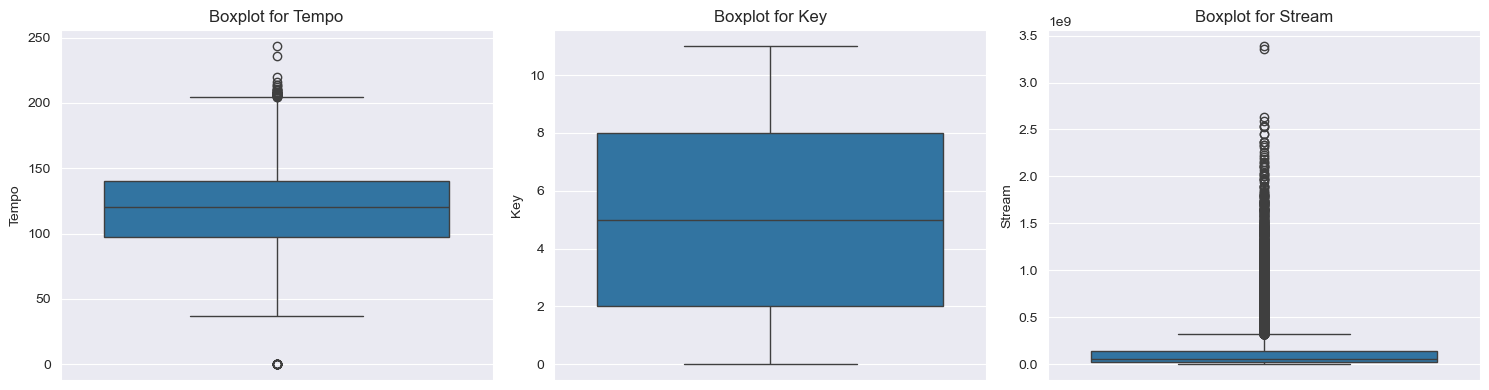

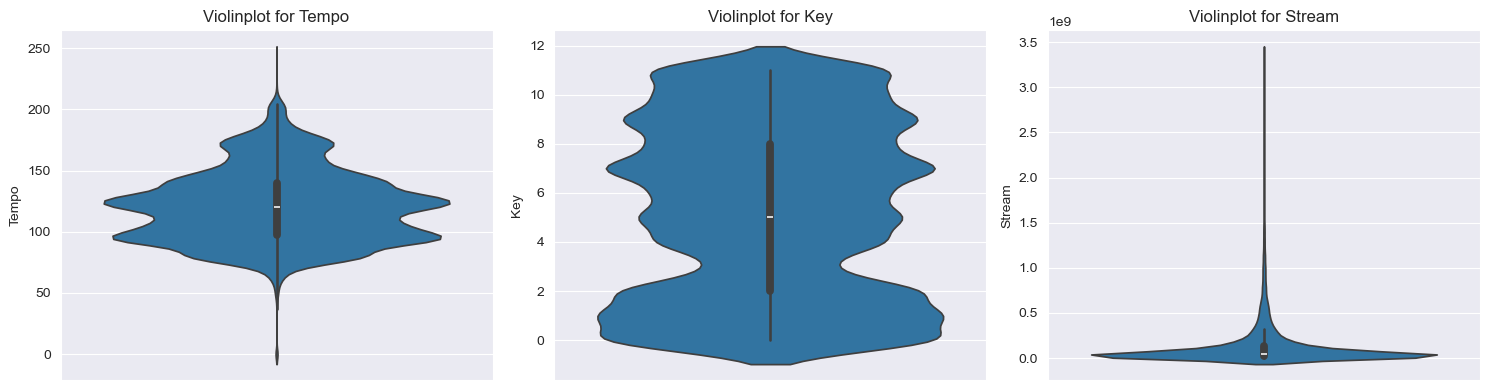

In [12]:
create_boxplot(numeric_columns[["Tempo", "Key", "Stream"]]) # few atributes that describe each song
create_violinplot(numeric_columns[["Tempo", "Key", "Stream"]])

As we can see, songs that are recorded in our database are:
- tempo'ed at mostly 100 - 150 bpm (standard for pop, rock, rap music)
- varied in key choice (peaks are at C, C#, G - and D# is the least popular)
- mostly lesser-known.

Also, to help visualize distribution of our numerical data using errorbars in seaborn library and simple pointplots.

In [13]:
def plot_errorbars_from_df(df, columns, error_spec=("sd", 1), jitter=0.1):
    """
    Plot errorbars from df function.

    """
    
    for column in columns:
        data = df[column].dropna()

        f, axs = plt.subplots(2, figsize=(10, 2), sharex=True, layout="tight", height_ratios=[0.5, 0.8]) #

        # Simple pointplot
        sns.pointplot(
            x=data,
            errorbar=error_spec, # creatin for error_spec - standard deviation for default
            capsize=0.6,
            color="tab:blue",
            ax=axs[0]
        )

        # Stripplot with raw data
        sns.stripplot(
             x=data,
            jitter=jitter,
            color="tab:blue",
            size=3,
            alpha=0.6,
            ax=axs[1]
        )

        axs[0].set_title(f"{column} – Mean ± {error_spec[1]}×{error_spec[0].upper()}")
        axs[1].set_xlabel(column)
        axs[0].set_ylabel("")
        axs[1].set_ylabel("")

        plt.tight_layout()
        os.makedirs('processed_data', exist_ok=True)
        os.makedirs('processed_data/processed_data_pointplots', exist_ok=True)
        plt.savefig(f'processed_data/processed_data_pointplots/{column}_pointplot_with_error.png') # saving at the end
    

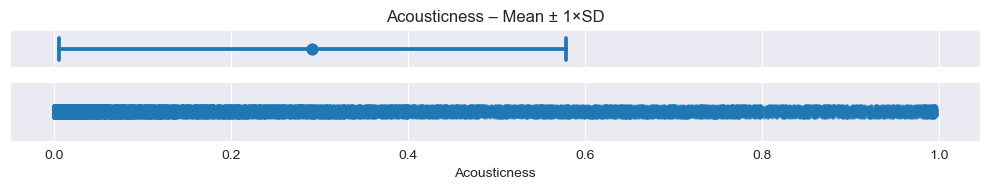

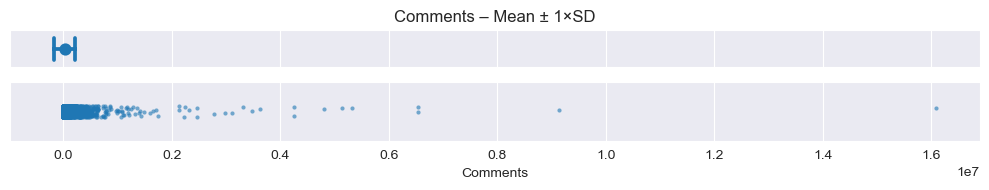

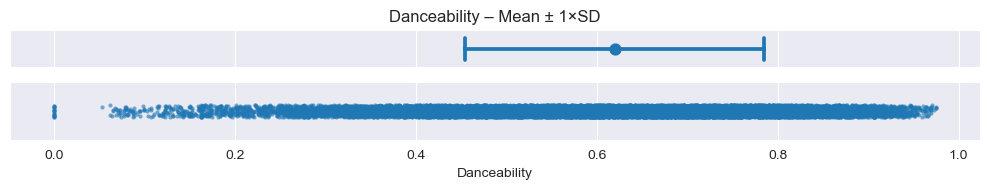

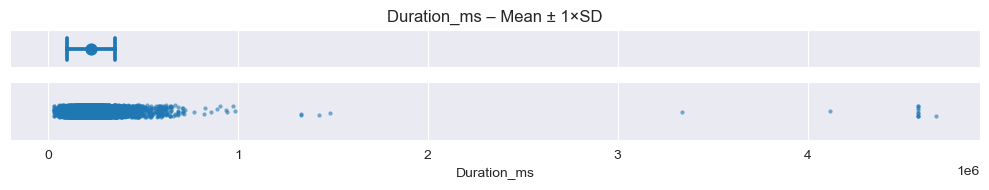

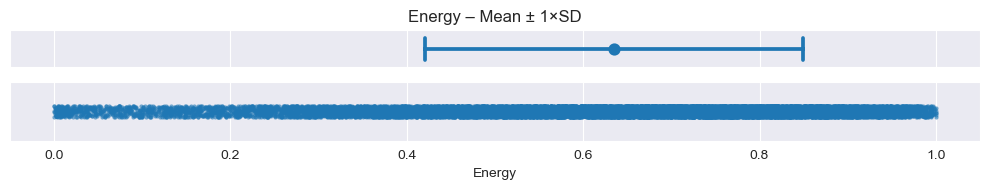

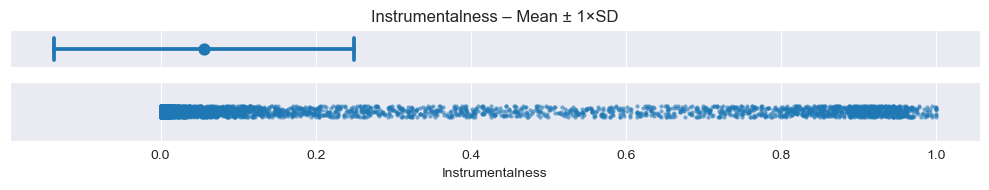

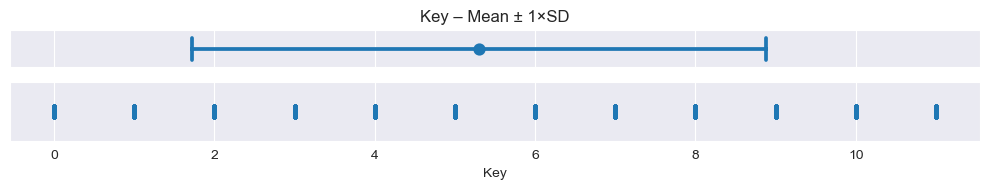

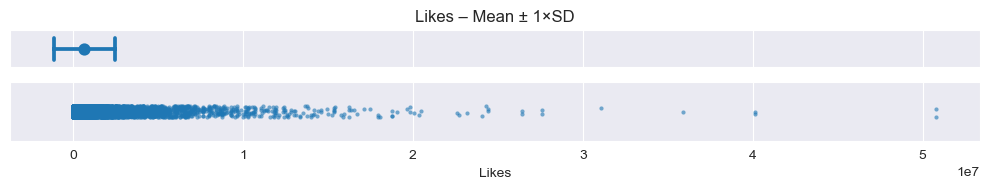

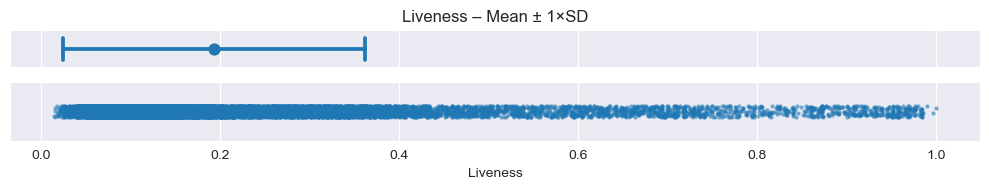

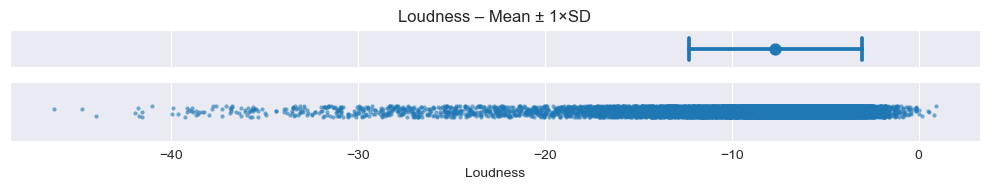

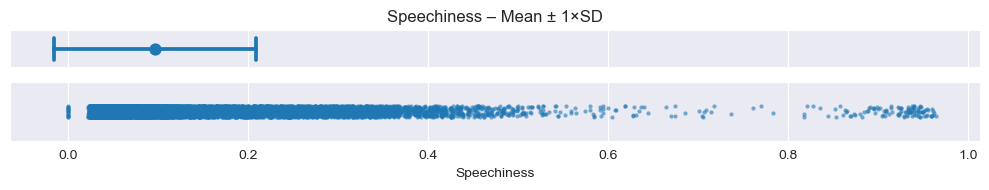

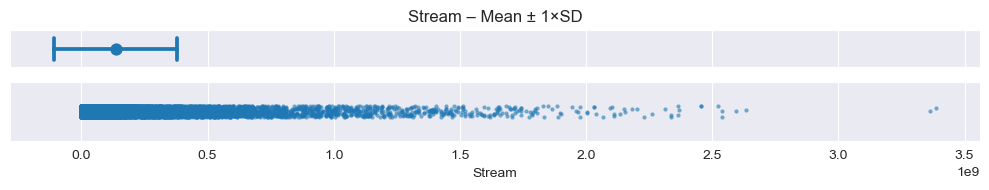

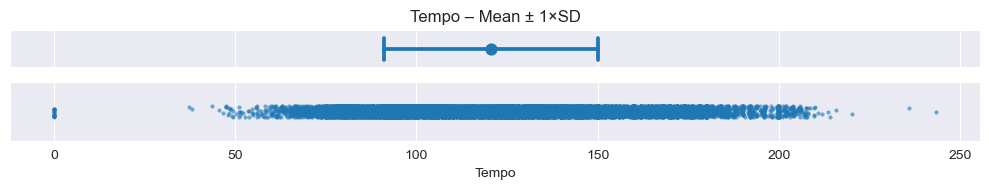

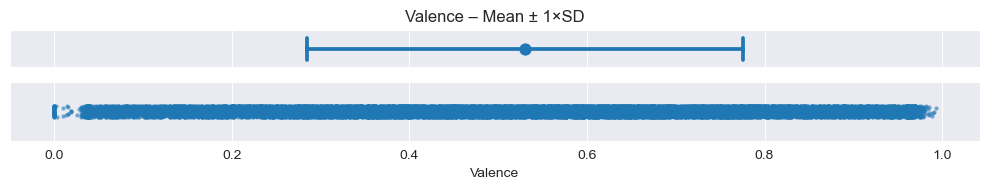

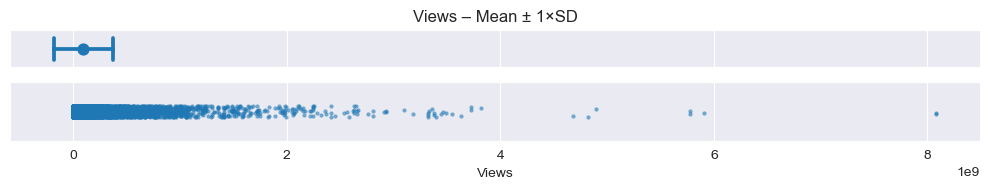

In [14]:
plot_errorbars_from_df(data, numeric_columns.columns)

As we can see our data varies significantly across most atributes.

Furthermore, to help us see more about each's atribute's distribution, we can also create simple histograms:

In [15]:
def histograms_from_df(df, columns, bins=100):
    """
    Histograms from df function.

    """

    for column in columns:
        sns.displot(data=df, x=column, bins=bins, kde=False, color='skyblue', height=4, aspect=2.5)
        plt.title(f'Histogram: {column}')
        plt.xlabel(column)
        plt.ylabel('Cardinality')
        
        plt.tight_layout()
        os.makedirs('processed_data/processed_data_histograms', exist_ok=True)
        plt.savefig(f'processed_data/processed_data_histograms/{column}_histogram.png') # saving at the end
        

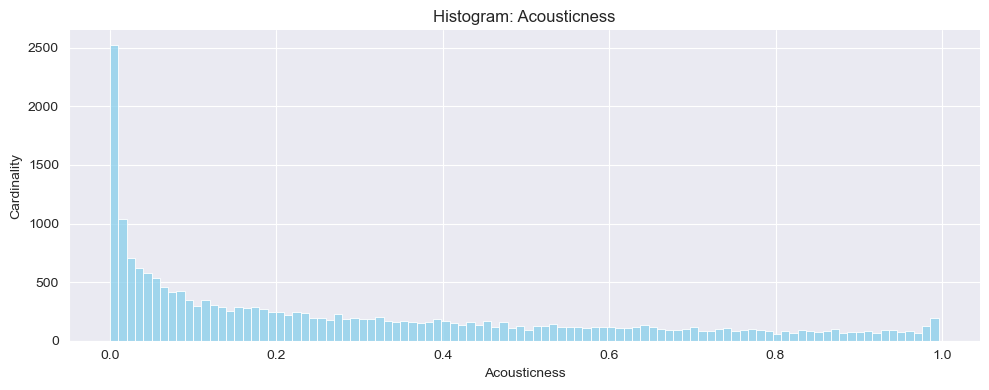

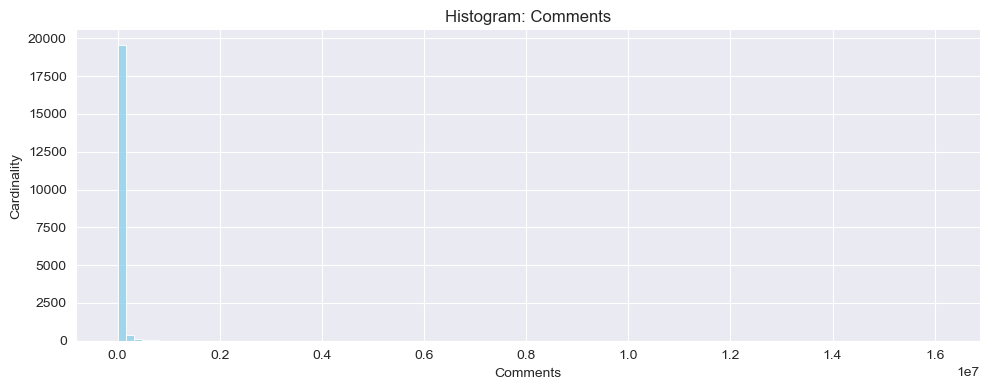

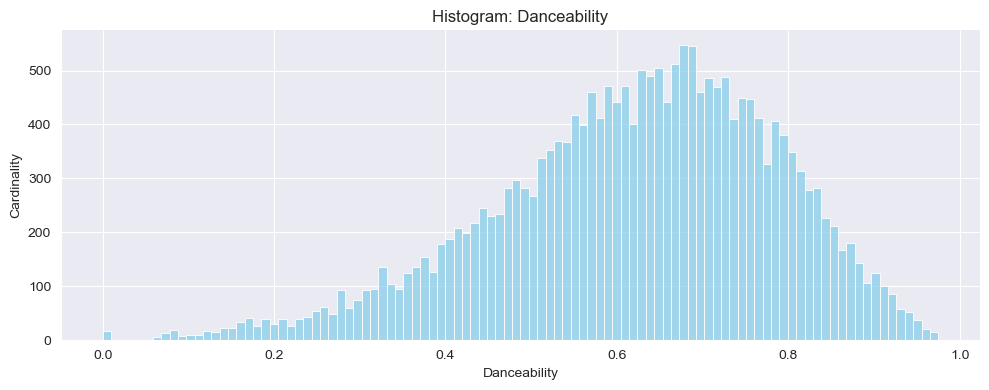

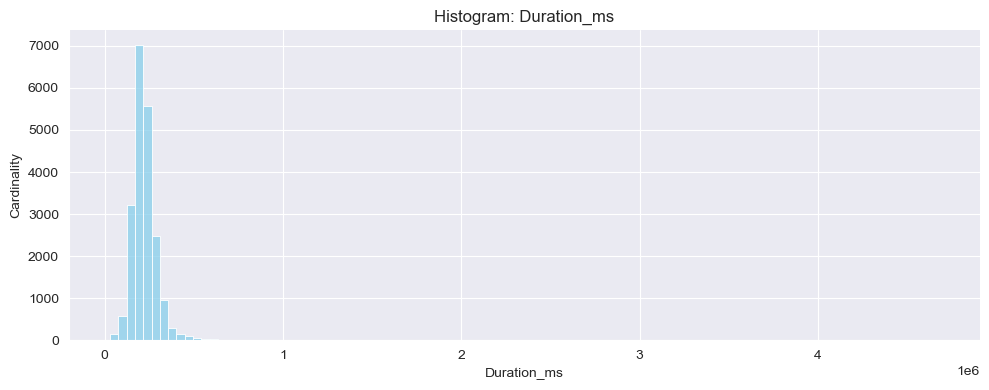

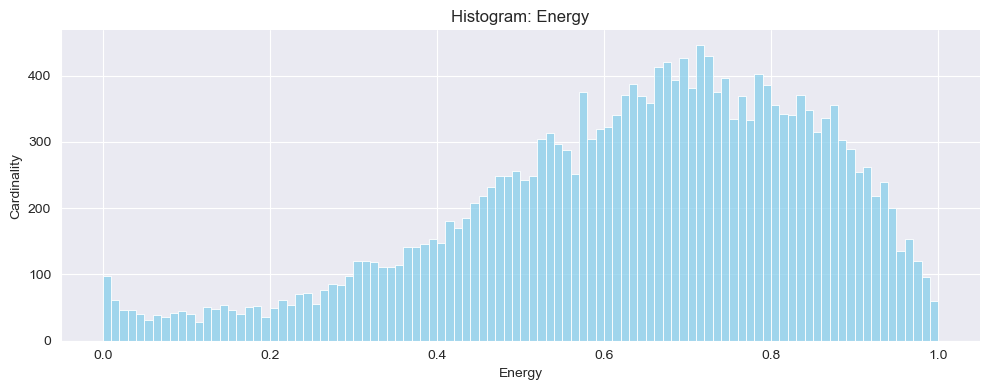

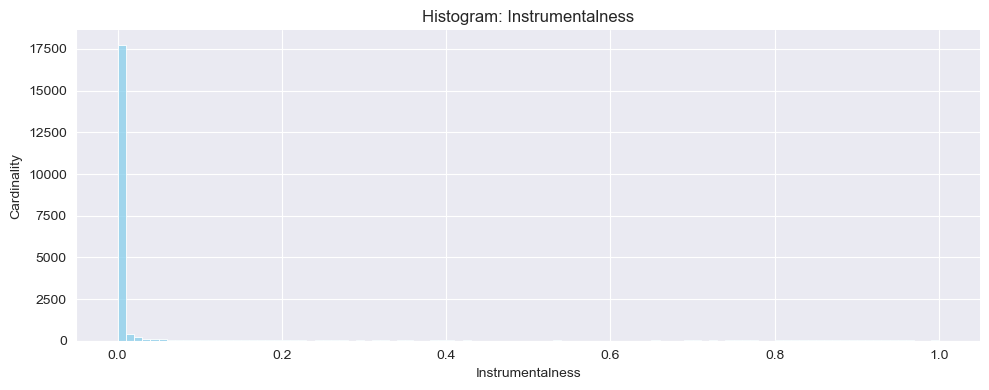

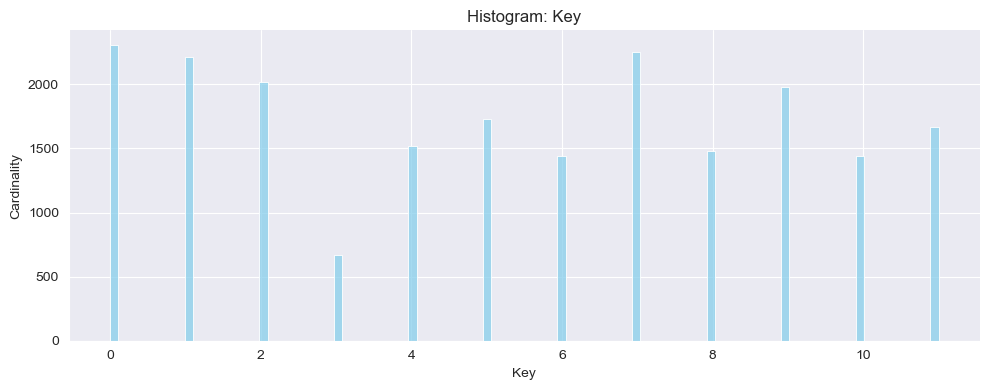

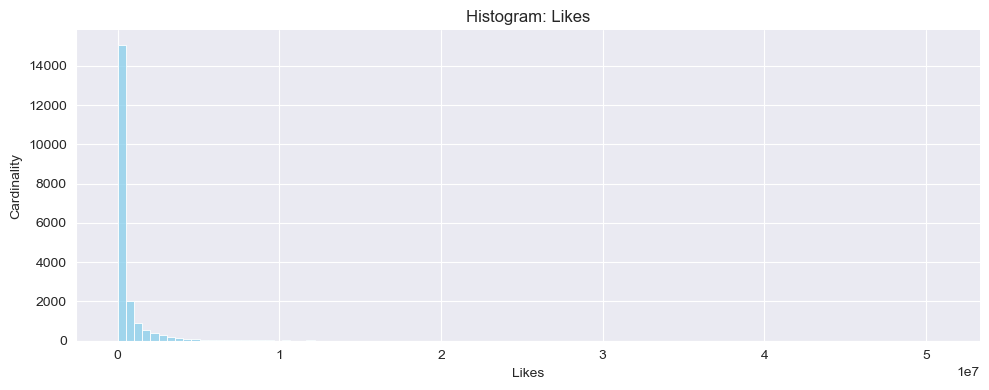

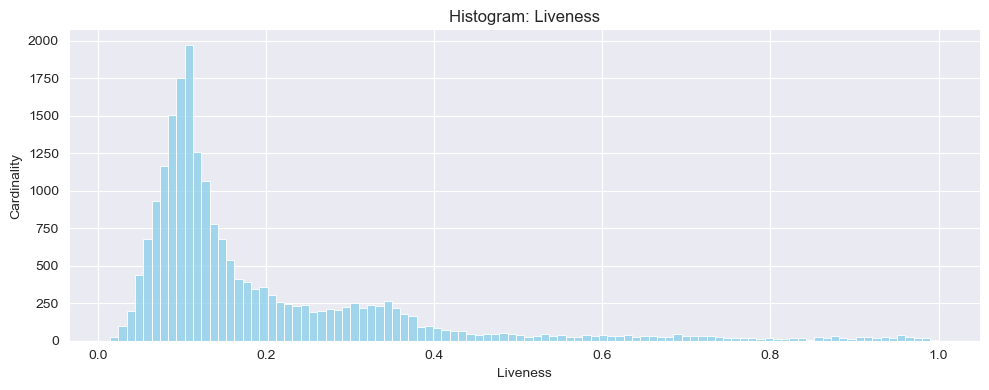

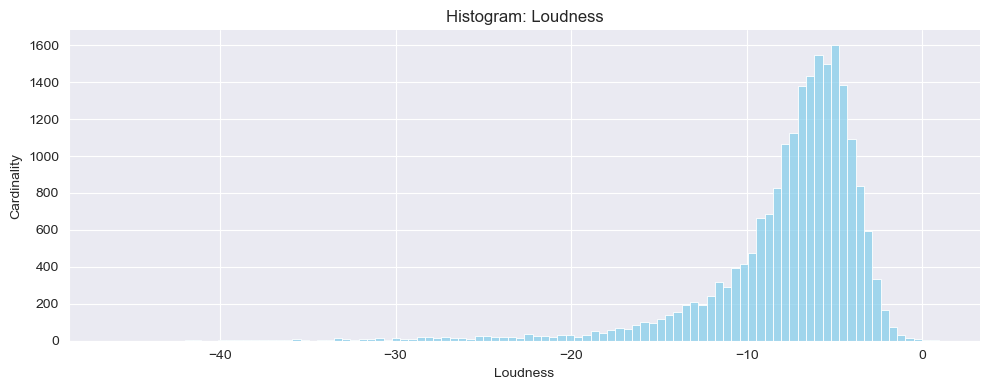

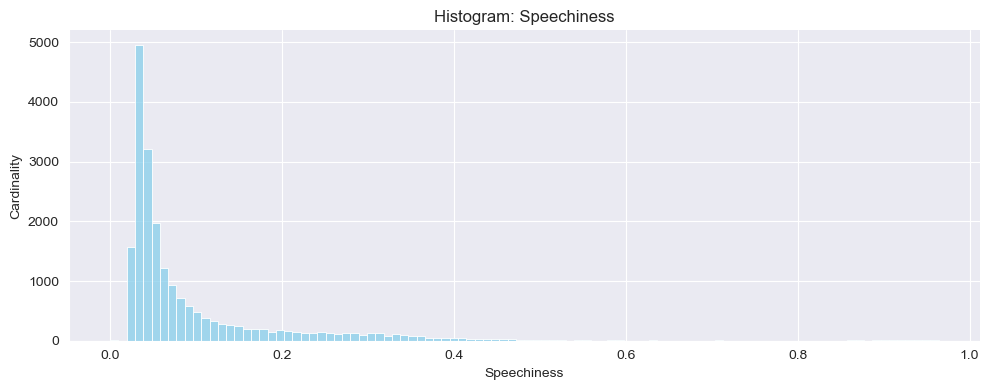

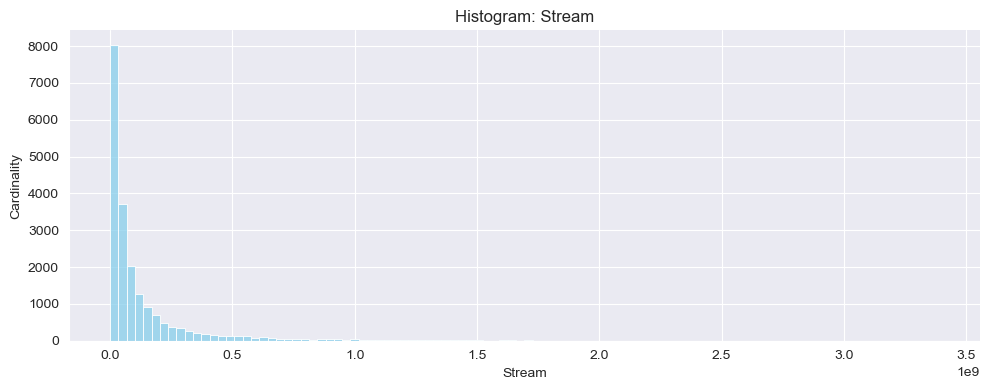

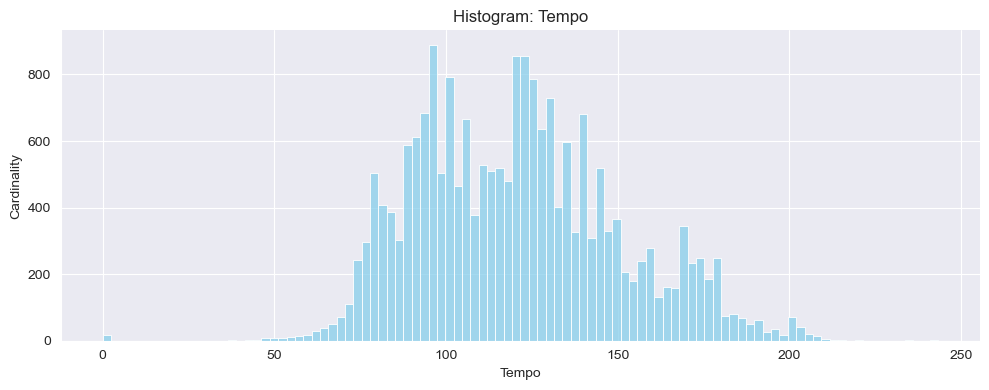

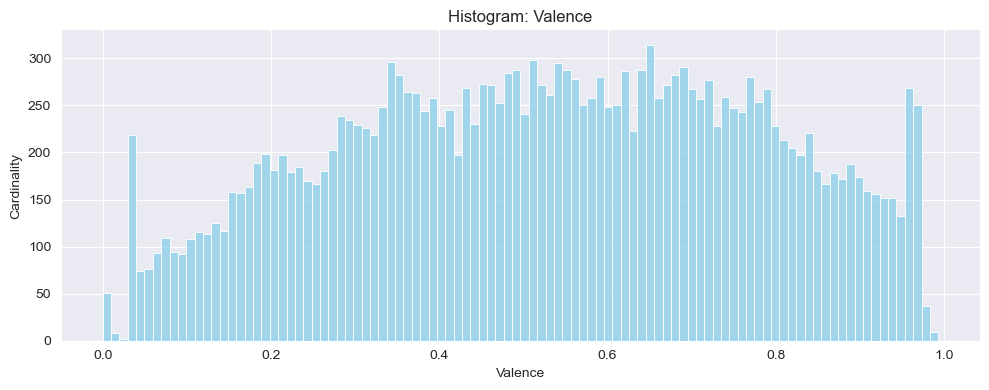

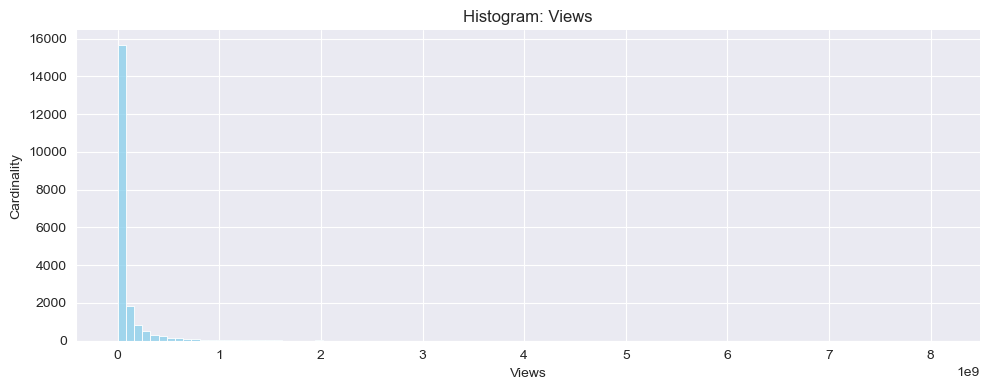

In [16]:
histograms_from_df(data, numeric_columns.columns)

As we can see:
- some distributions (ex. Loudness, Danceability) are pretty close to a normal (Gauss) distribution,
- others tend to be follow rapid logarytmic descend (ex. Likes and Speechiness),
- only few atributes (ex. Key) has a discrete distribution.



#                                                        Correlations



Now, when we know what data are we working with, let's seek some interesting correlations.

Firstly, let's stick to histograms for a moment and see if we can find some correlaions with them.

In [17]:
def cond_histograms_from_df(df, columns, cond, bins=100):
    """
    Cond histograms from df function.

    """

    for column in columns:
        g=sns.displot(data=df, x=column, bins=bins, palette="tab10", hue=cond, kde=False, color='skyblue', height=4, aspect=2.5)
        plt.title(f'Histogram: {column}')
        g._legend.set_bbox_to_anchor((1.05, 0.5))  # prawa strona, wyśrodkowana w pionie
        plt.xlabel(column)
        plt.ylabel('Cardinality')
        
        plt.tight_layout()
        os.makedirs('processed_data/processed_data_cond_histograms', exist_ok=True)
        plt.savefig(f'processed_data/processed_data_cond_histograms/{column}_cond_histogram.png') # saving at the end

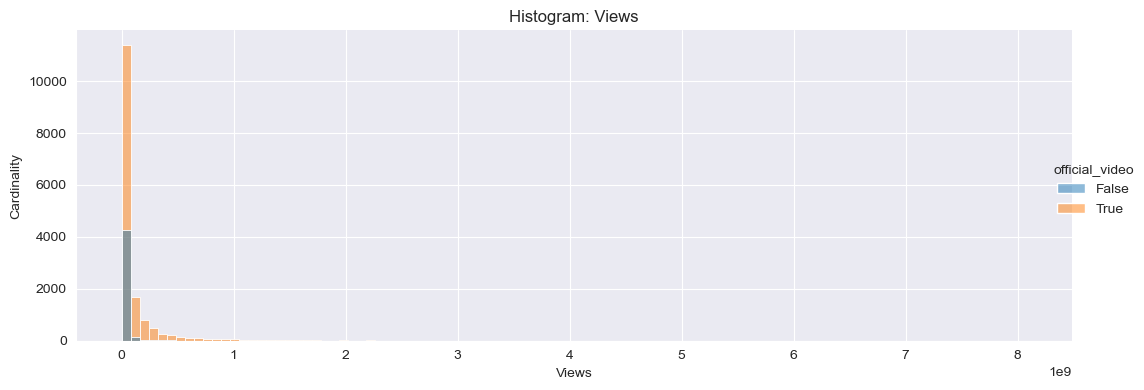

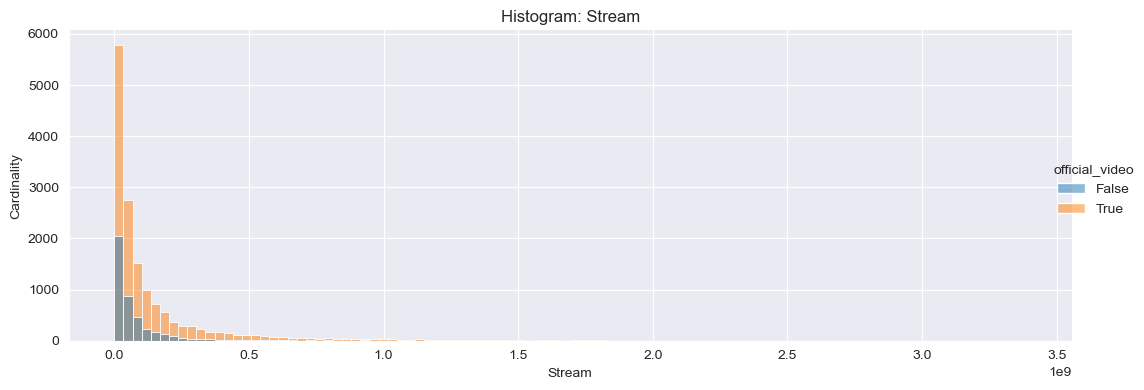

In [18]:
cond_histograms_from_df(data, ["Views", "Stream"], "official_video")

Concluding :
- songs that don't have and official video are more likely to have less views (and suprisingly - less streams on spotify),
- official video dampens the popularity drop - even if just a little.

Next are some anylisys with heatmap:

In [19]:
def heatmap_from_df(df, x, y, value = "Cardinality", round_to=1, median=True):
    """
    Heatmap from df function.

    """

    df = df.copy() # not to change the original

    # roundind of the x and y values
    
    if np.issubdtype(df[x].dtype, np.number):
        df[x] = df[x].round(round_to)
        
    if np.issubdtype(df[y].dtype, np.number):
        df[y] = df[y].round(round_to)

    if value == "Cardinality": # count cardinality by default
        tab = df.pivot_table(index=y, columns=x, aggfunc='size', fill_value=0)
    else:
        tab = df.pivot_table(index=y, columns=x, values=value, aggfunc='median' if median else 'mean')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(tab, annot=False, cmap="YlGnBu")
    
    plt.gca().invert_yaxis() # turn y axis correct way

    plt.title(f"Heatmap: {value} / {y} and {x}")
    plt.tight_layout()

    os.makedirs('processed_data/processed_data_heatmaps', exist_ok=True)
    plt.savefig(f'processed_data/processed_data_heatmaps/{y}-{x}_heatmap.png')

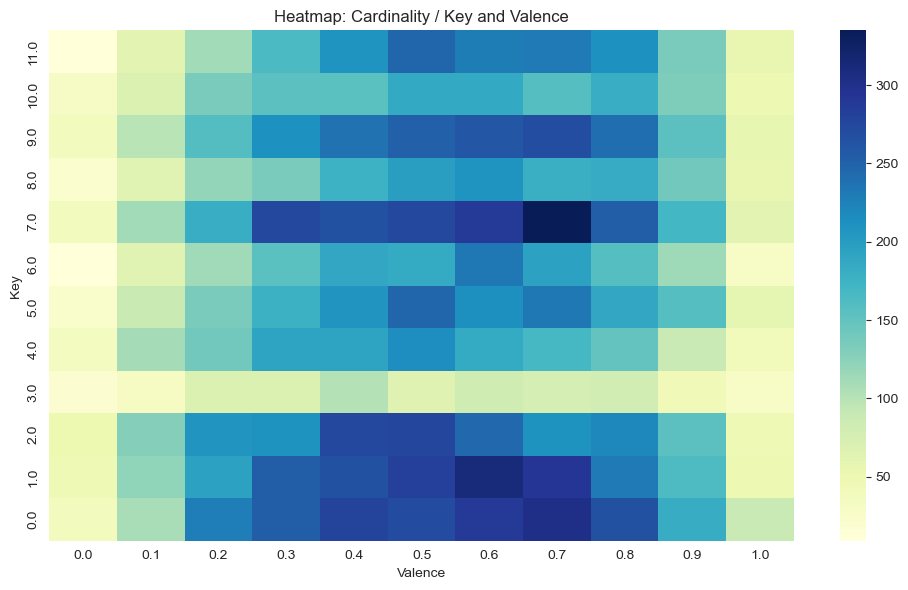

In [20]:
heatmap_from_df(data, "Valence", "Key")

As we can see happy songs are mostly written in C, C# and G, while the opposites are mostly written in D and G.

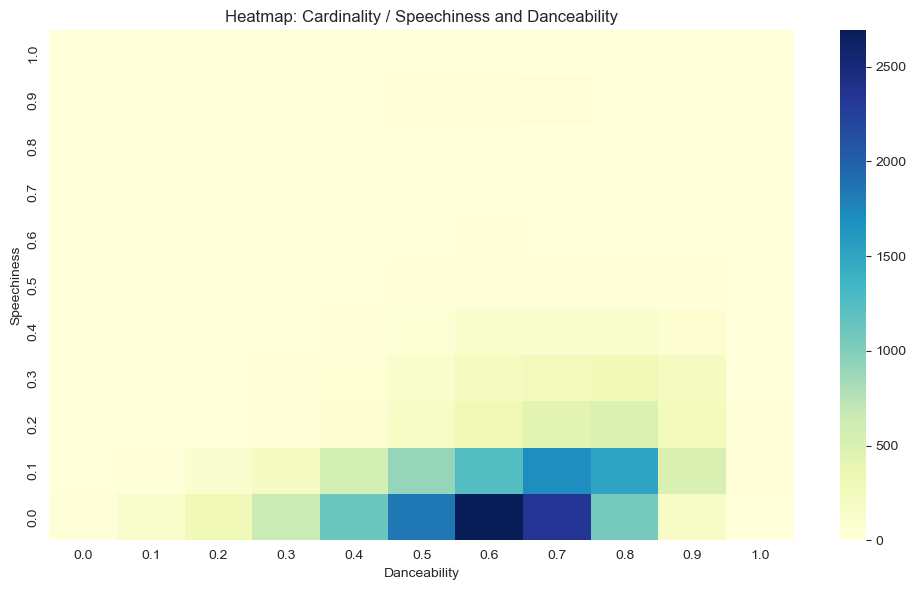

In [21]:
heatmap_from_df(data, "Danceability", "Speechiness")

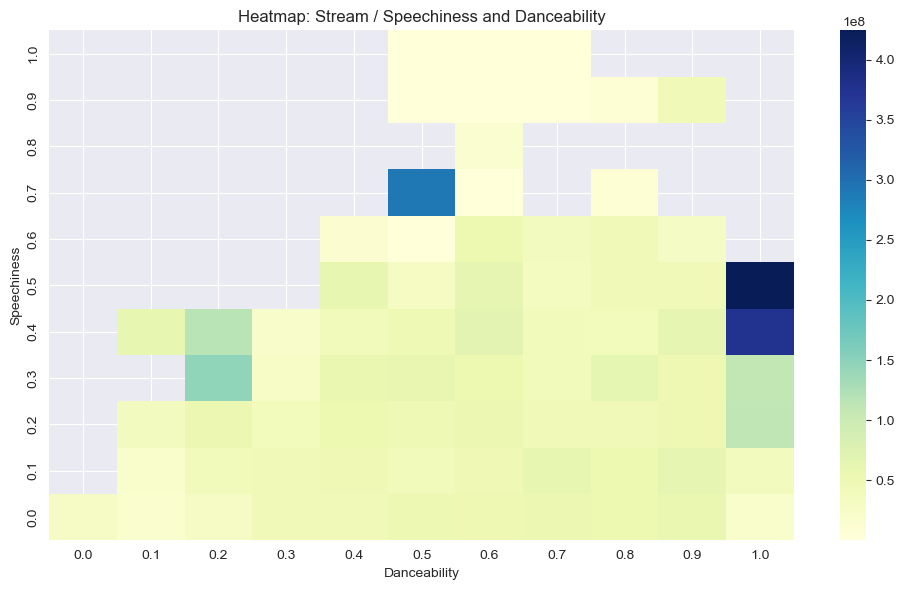

In [22]:
heatmap_from_df(data, "Danceability", "Speechiness", "Stream")

As expected, songs that are easy to dance to, have low level of speech present, but interestingly, the most popular of them are those which have higher speech presence.

Additionally, we can conclude 3 main popular groups: 
- recognized - (0.2 ; 0.3) - probably things like soundtracks, ambient music,
- well-known - (0.5 ; 0.7) - high speech level indicates styles like rap and similar,
- famous - (1.0 ; 0.4-0.5) - high danceability and medium speech presence - mostly pop, edm.

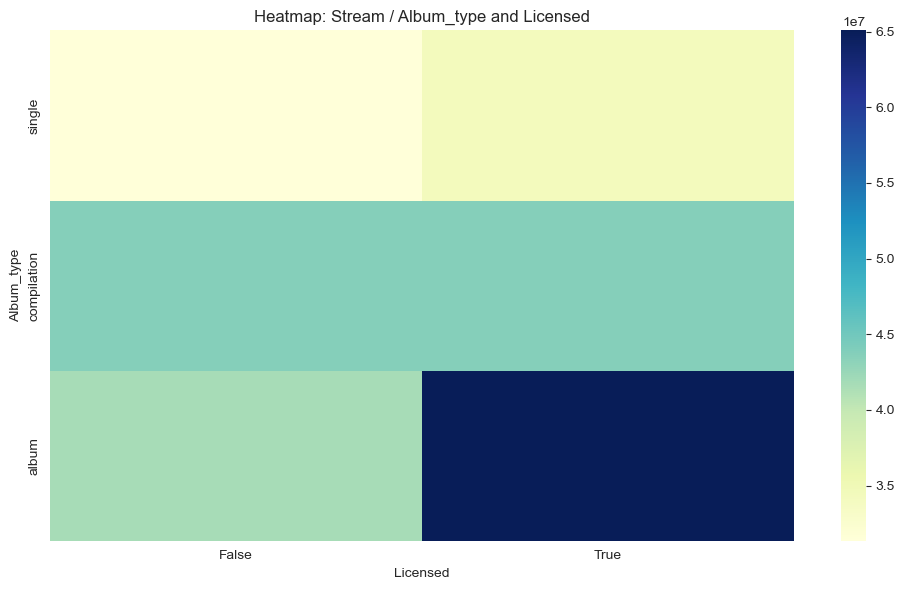

In [23]:
heatmap_from_df(data, "Licensed", "Album_type", "Stream")

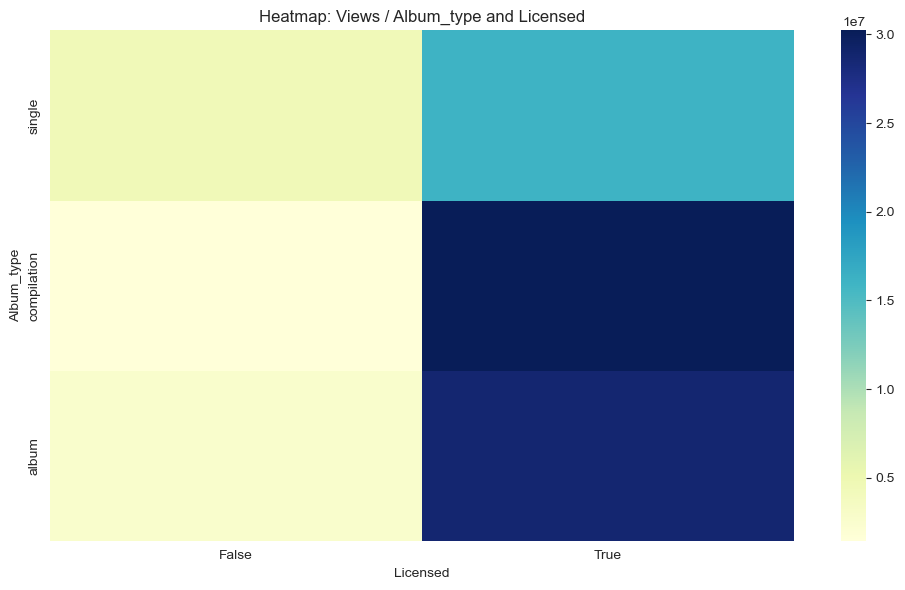

In [24]:
heatmap_from_df(data, "Licensed", "Album_type", "Views")

Another interesting detail:
- albums on Spotify attract the most attention, but the difference between licensed and unlicensed (ex. remixes) uploads is not that big,
- there is a clear difference in views between lincensed and unlicensed content on Youtube, as well as pretty fair distribution between different album types.

Now, let's see linear regression of some interesting data.

In [25]:
def regplot_from_df(df, x, y,  order=1, round_to=None):
    """
    Regplot from df function.

    """
    df = df.copy()  # copying in order not to modify the original

    # Rounding of data if given
    if round_to is not None:
        if np.issubdtype(df[x].dtype, np.number):
            df[x] = df[x].round(round_to)
        if np.issubdtype(df[y].dtype, np.number):
            df[y] = df[y].round(round_to)

    plt.figure(figsize=(10, 6))
   
    sns.regplot(data=df, x=x, y=y, order=order, color='tab:blue', x_jitter=0.1, 
    line_kws={
        "color": "red",      # kolor linii
        "linewidth": 2.5,    # grubość
        "linestyle": "--"    # styl przerywany
    },
    scatter_kws={"alpha": 0.5}
    )

    plt.title(f"Regplot: {y} / {x}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)
    plt.tight_layout()

    os.makedirs('processed_data/processed_data_regplots', exist_ok=True)
    plt.savefig(f'processed_data/processed_data_regplots/{x}-{y}_regplot.png')

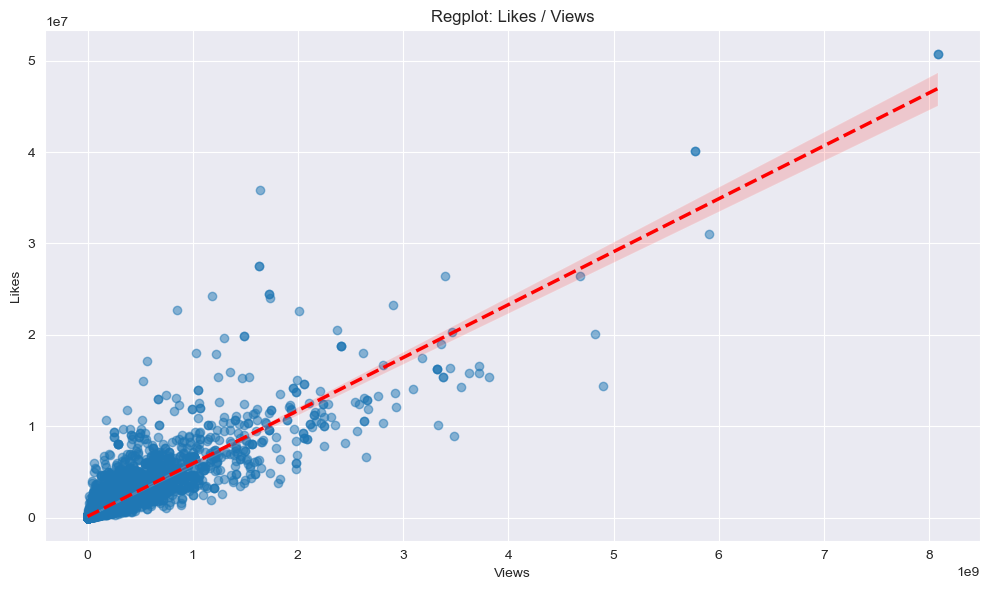

In [26]:
regplot_from_df(data, "Views", "Likes")

It may be a pretty obvious connection, but as we can see, on average, more views = more likes.

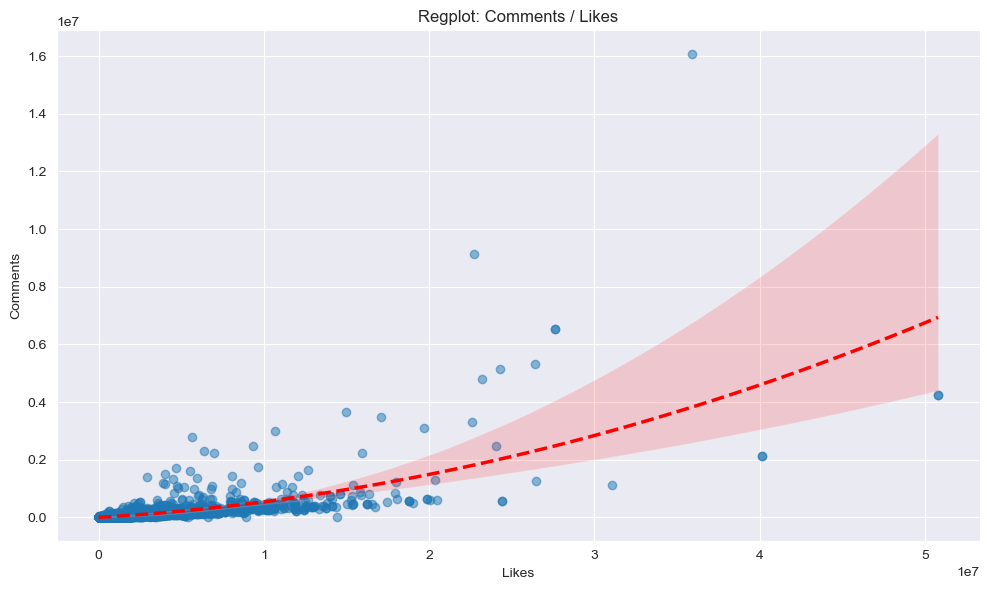

In [27]:
regplot_from_df(data, "Likes", "Comments", 2, 0)

The more liked the song, the more comments will it get. We can observe a start of a exponential growth (unluckily we don't have the dislike data).



#                                                    Reduction of dimentionality



<Axes: >

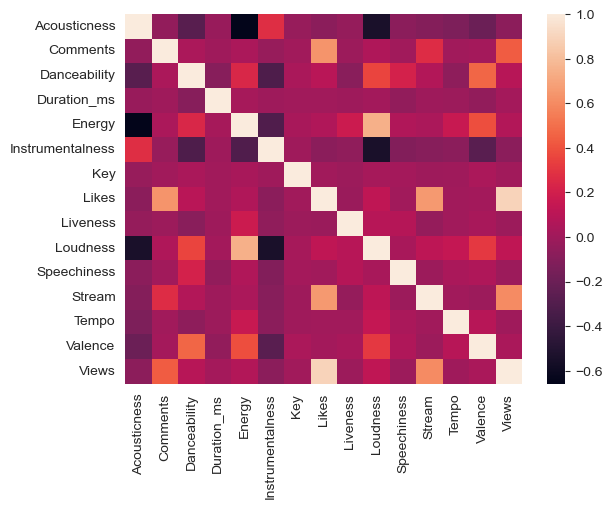

In [28]:
sns.heatmap(numeric_columns.corr()) # check the correlation of the dataset

Some of our atributes are strongly correlated to each other. That means this dataset qualifies for dimentional reduction.

We can try and reduce dimentionality of our data. To do that we will need to use PCA - Principal Component Analysis and scaler that will help us transform our data.

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

Firstly, we need to standardize features - that means to transform the data to scale each column to have a mean of 0 and a standard deviation of 1. This will eliminate problem with measurment units.

In [30]:
def scale_data(numeric_data):
    df_clean = numeric_data.dropna() # eliminate every "blank" field
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_clean) # scaling to avoid measuring problems (like different units
    return scaled_data

It is time to apply PCA algorithm from imported library and check if data will now be uncorrelated.

In [31]:
def PCA_reduce(scaled_data):
    pca = PCA(n_components=2) # choosing to transform to 2D
    pca_result = pca.fit_transform(scaled_data) # transforming
    
    df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    return df_pca

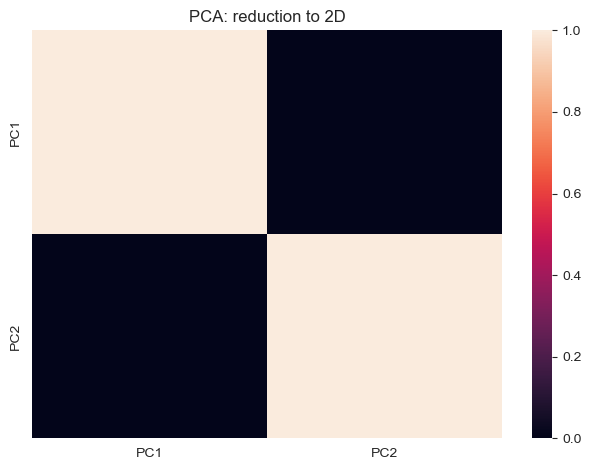

In [32]:
reduced_data = PCA_reduce(scale_data(numeric_columns))
sns.heatmap(data=reduced_data.corr())
plt.title("PCA: reduction to 2D")
plt.tight_layout()

In the PCA analysis, the data were transformed into two principal components (PC1 and PC2), which are linear combinations of all the original variables. The first component (PC1) explains the largest possible part of the variance in the data, while the second component (PC2) explains the next largest, while remaining orthogonal (not correlated) to the first. This allows dimensionality to be reduced and data to be visualised in two dimensions without significant loss of information.


In [33]:
reduced_data.head()

,PC1,PC2
0,4.115529,3.047216
1,1.127773,-0.170664
2,0.950709,-1.093800
3,0.667109,1.012214
4,2.802008,2.886543


Quick look at how that table looks. Then it is time to save our work.

In [34]:
save_to_csv(reduced_data=reduced_data)

Saved: processed_data/reduced_data.csv


## Summary
In this notebook, we processed and analyzed log data using a series of modular functions. We found out some interesting correlations between data and set up our dataset for future, more advanced, analysis.